---
# <span style="color:blue">**Visual search with k-NN**</span>
---

---
### **Load merged training and validation data & test data**
---

In [1]:
import functions as fn

X_te, y_te, y_te_labels, test_features, te_filenames = fn.load_data('testfile_mobile_v2.npz', 'Test')
X_tr_merged, y_tr_merged, y_tr_labels_merged, train_features_merged, train_filenames_merged = fn.merge_tr_val_sets()

Test data info:
---------------
X: (50, 224, 224, 3)
y: (50, 6)
labels: (6,)
features: (50, 1280)
filenames (50,) 

Training data info:
-------------------
X: (280, 224, 224, 3)
y: (280, 6)
labels: (6,)
features: (280, 1280)
filenames (280,) 

Validation data info:
---------------------
X: (139, 224, 224, 3)
y: (139, 6)
labels: (6,)
features: (139, 1280)
filenames (139,) 

merged training and validation data info:
-----------------------------------------
X: (419, 224, 224, 3)
y: (419, 6)
labels: (6,)
features: (419, 1280)
filenames (419,) 



---
### **Preprocess input data**
---

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Normalizer

pipe = Pipeline([
    ('scaler', Normalizer()),
    ('pca', PCA(n_components=260)),
])

pipe.fit(train_features_merged)

processed_train_features = pipe.transform(train_features_merged)
processed_test_features = pipe.transform(test_features)

---
### **Search for the best kNN parameters for 10 neighbors**
---

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Define the kNN estimator
estimator_KNN = KNeighborsClassifier(algorithm='auto', n_neighbors=10)

# Define parameters to search
parameters_KNN = {
    #'n_neighbors': (1,21, 1),
    'leaf_size': (1,40,1),
    'p': (1,2),
    'weights': ('uniform', 'distance'),
    'metric': ('minkowski', 'euclidean','chebyshev')
}
                   
# Define GridSearch
grid_search_KNN = GridSearchCV(
    estimator=estimator_KNN,
    param_grid=parameters_KNN,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 10
)

# Fit GridSearchCV
grid_search_KNN.fit(processed_train_features, y_tr_merged)

# Print results
print('Best paramemeters for n_neighbors=10:',grid_search_KNN.best_params_) 
print('Best validation score:{:.2f}'.format(grid_search_KNN.best_score_))
print('Test score:', grid_search_KNN.score(processed_test_features, y_te))

Best paramemeters for n_neighbors=10: {'leaf_size': 1, 'metric': 'minkowski', 'p': 2, 'weights': 'distance'}
Best validation score:0.83
Test score: 0.98


/home/osidirop/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/model_selection/_search.py:842: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


---
### **Save test accuracy**
---

In [4]:
fn.save_test_accuracy('knn.csv','kNN', grid_search_KNN.score(processed_test_features, y_te))

---
### **Fit kNN with best params**
---

In [5]:
# Define kNN with best params
knn = KNeighborsClassifier(algorithm='auto', 
                           n_neighbors=10,
                           leaf_size=grid_search_KNN.best_params_['leaf_size'],
                           metric=grid_search_KNN.best_params_['metric'],
                           p=grid_search_KNN.best_params_['p'],
                           weights=grid_search_KNN.best_params_['weights']                           
                          )

# Fit kNN
knn.fit(processed_train_features, y_tr_merged)

# Get distances and indices for test features
distances, indices = knn.kneighbors(processed_test_features, return_distance=True)

---
### **Plot a test image and its 10 neighbors from the training data**
---

In [6]:
# Function to plot similar images from the training set
def similar_images(indices, distances):

    plt.figure(figsize=(20,10))
    plotnumber = 1    
    for index,d in zip(indices, distances):
        if plotnumber<=len(indices) :
            ax = plt.subplot(1,10,plotnumber)
            plt.imshow(X_tr_merged[index])      
            ax.get_xaxis().set_visible(False) # disable x-axis
            ax.get_yaxis().set_visible(False) # disable y-axis 
            ax.set_title('d:{:.2f}'.format(d))
            plotnumber+=1
    plt.tight_layout()

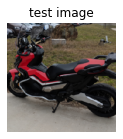

 Similar images from training set:


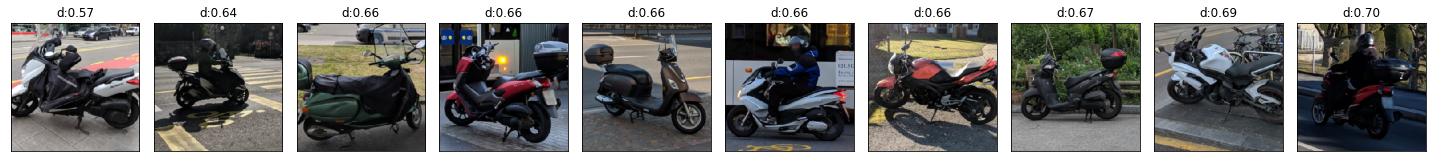

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(2,2))
plt.imshow(X_te[30])
plt.title('test image')
plt.axis('off')
plt.show()
print('\033[1m Similar images from training set:\033[0m')
similar_images(indices[30], distances[30])
